# Modeling: Predicting Food Affordability

RQ4: When all predictors are considered together, which variables contribute the most to predicting affordability?

Target: affordability_ratio is right-skewed, so we model log1p(affordability_ratio).
Models:
- Dummy baseline (predict mean)
- Linear regression with one-hot encoding for categorical features

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance

RANDOM_STATE = 159
np.random.seed(RANDOM_STATE)

DATA_PATH = Path("./data/food_affordability.csv")
OUT_DIR = Path("./outputs"); OUT_DIR.mkdir(exist_ok=True)
FIG_DIR = Path("./figures"); FIG_DIR.mkdir(exist_ok=True)

In [2]:
df = pd.read_csv(DATA_PATH)

df = df[df["affordability_ratio"].notna() & df["cost_yr"].notna()].copy()

drop_cols = ["version", "ind_definition", "ind_id", "reportyear",
             "LL95_affordability_ratio", "UL95_affordability_ratio",
             "se_food_afford", "rse_food_afford",
             "county_name", "county_fips", "region_code",
             "ave_fam_size"]

df = df.drop(columns=drop_cols, errors="ignore")

df.shape

(3473, 11)

In [3]:
TARGET = "affordability_ratio"
FEATURES = ["median_income", "cost_yr", "region_name", "geotype", "race_eth_name"]

# Drop rows missing any required feature
df_model = df.dropna(subset=[TARGET] + FEATURES).copy()

X = df_model[FEATURES]
y = df_model[TARGET]

X.head(), y.describe()

(   median_income      cost_yr region_name geotype race_eth_name
 0        23777.0  7508.289655  California      CA          AIAN
 1        38508.0  7508.289655  California      CA         Asian
 2        26192.0  7508.289655  California      CA     AfricanAm
 3        22858.0  7508.289655  California      CA        Latino
 4        36737.0  7508.289655  California      CA         NHOPI,
 count    3473.000000
 mean        0.357114
 std         0.451169
 min         0.021258
 25%         0.158028
 50%         0.245429
 75%         0.381940
 max         4.852371
 Name: affordability_ratio, dtype: float64)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

In [6]:
cat_cols = ["region_name", "geotype", "race_eth_name"]
num_cols = ["median_income", "cost_yr"]

pre = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("scaler", StandardScaler())]), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ],
    remainder="drop",
)

In [7]:
dummy = DummyRegressor(strategy="mean")

lin = Pipeline([
    ("pre", pre),
    ("reg", LinearRegression())
])

lin_t = TransformedTargetRegressor(
    regressor=lin, func=np.log1p, inverse_func=np.expm1
)

In [8]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rows = []

# Dummy
dummy.fit(X_train, y_train)
pred_dummy = dummy.predict(X_test)
rows.append({
    "model": "Dummy(mean)",
    "RMSE": rmse(y_test, pred_dummy),
    "MAE": mean_absolute_error(y_test, pred_dummy),
    "R2": r2_score(y_test, pred_dummy),
})

# Linear
lin_t.fit(X_train, y_train)
pred_lin = lin_t.predict(X_test)
rows.append({
    "model": "Linear(log1p target)",
    "RMSE": rmse(y_test, pred_lin),
    "MAE": mean_absolute_error(y_test, pred_lin),
    "R2": r2_score(y_test, pred_lin),
})

metrics = pd.DataFrame(rows).sort_values("RMSE")
metrics

,model,RMSE,MAE,R2
1,Linear(log1p target),0.340012,0.145797,0.263215
0,Dummy(mean),0.396309,0.219434,-0.000969


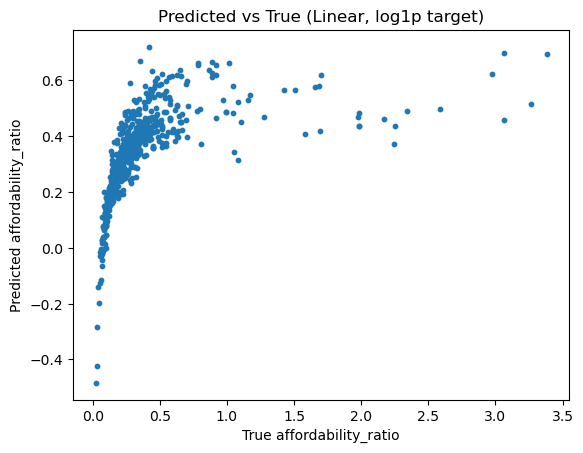

In [9]:
plt.figure()
plt.scatter(y_test, pred_lin, s=10)
plt.xlabel("True affordability_ratio")
plt.ylabel("Predicted affordability_ratio")
plt.title("Predicted vs True (Linear, log1p target)")
plt.savefig(FIG_DIR / "pred_vs_true_linear_minimal.png", dpi=150, bbox_inches="tight")
plt.show()

In [10]:
imp = permutation_importance(
    lin_t, X_test, y_test,
    n_repeats=20, random_state=RANDOM_STATE, n_jobs=-1
)

imp_df = pd.DataFrame({
    "feature": X_test.columns,
    "importance_mean": imp.importances_mean,
    "importance_std": imp.importances_std,
}).sort_values("importance_mean", ascending=False)

imp_df

,feature,importance_mean,importance_std
0,median_income,0.342499,0.029228
2,region_name,0.026492,0.009055
3,geotype,0.009770,0.003911
4,race_eth_name,0.002602,0.004642
1,cost_yr,-0.003561,0.006071


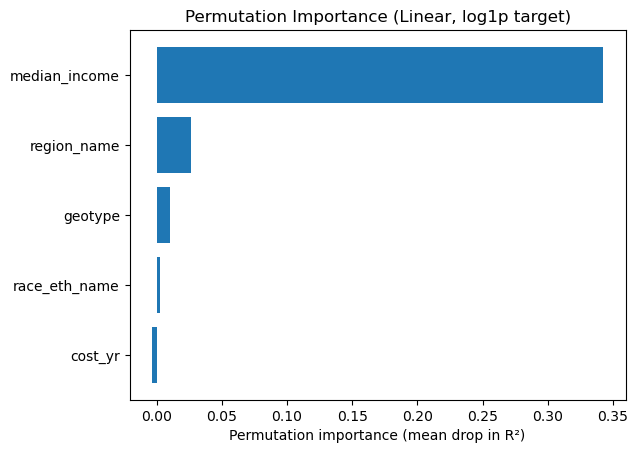

In [11]:
imp_df.to_csv(OUT_DIR / "perm_importance_linear_minimal.csv", index=False)

plt.figure()
plt.barh(imp_df["feature"][::-1], imp_df["importance_mean"][::-1])
plt.xlabel("Permutation importance (mean drop in R²)")
plt.title("Permutation Importance (Linear, log1p target)")
plt.savefig(FIG_DIR / "perm_importance_linear_minimal.png", dpi=150, bbox_inches="tight")
plt.show()